In [1]:
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import torch 
from torch import nn
import os
from torch.utils.data import Dataset,DataLoader
import torchvision.datasets as datasets
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch import nn, optim

import torchvision   
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import matplotlib.image as img
from torch.utils.data import Sampler
from torch.utils.data import BatchSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2


In [2]:
import os
os.getcwd()
# place the files in your IDE working dicrectory .
labels = pd.read_csv('C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/train.csv')
submission = pd.read_csv('C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/sample_submission.csv')

train_path = 'C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/train_images'
test_path = 'C:/Users/malji/Datasets/HW4_Data/classification_data/test_data'
display(labels.head())
display(submission.head())

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


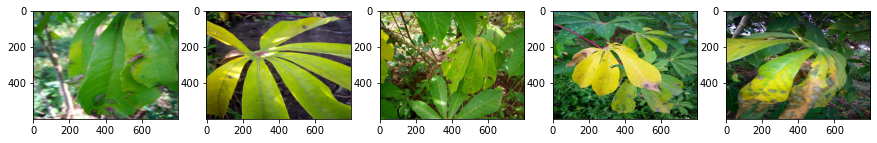

In [3]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['label'] == 0]['image_id'][-5:]):
    path = os.path.join('C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/train_images',idx)
    ax[i].imshow(img.imread(path))


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


In [5]:
class CassavaDateset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label


In [6]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return A.Compose([
            RandomResizedCrop(512, 512),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return A.Compose([
            CenterCrop(512, 512, p=1.),
            Resize(512, 512),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)


In [7]:
data_transform = get_train_transforms()

val_transform = get_valid_transforms()

dataset = CassavaDateset(labels, 'C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/train_images', data_transform)


In [8]:
# num_epochs = 35
# num_classes = 2
# batch_size = 25
# learning_rate = 0.001
# for label smothing
lr = 8e-6   # * batch_size
weight_decay = 2e-5
pos_weight   = 3.2
label_smoothing = 0.03

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [10]:

train_set, val_set = torch.utils.data.random_split(dataset, [17097, 4300])

train_loader = DataLoader(train_set, batch_size = 10, shuffle = True)
val_loader = DataLoader(val_set, batch_size = 10, shuffle = False)


In [11]:
print(f'Number of training examples: {len(train_set)}')
print(f'Number of validation examples: {len(val_set)}')

Number of training examples: 17097
Number of validation examples: 4300


In [12]:
# # loading datasets
# train_data = datasets.ImageFolder(root='C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/train_images', 
#                                                  transform=torchvision.transforms.ToTensor())

# # test_data = datasets.ImageFolder(root='C:/Users/malji/Datasets/HW4_Data/classification_data/test_data', 
# #                                                transform=torchvision.transforms.ToTensor())

In [13]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [14]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

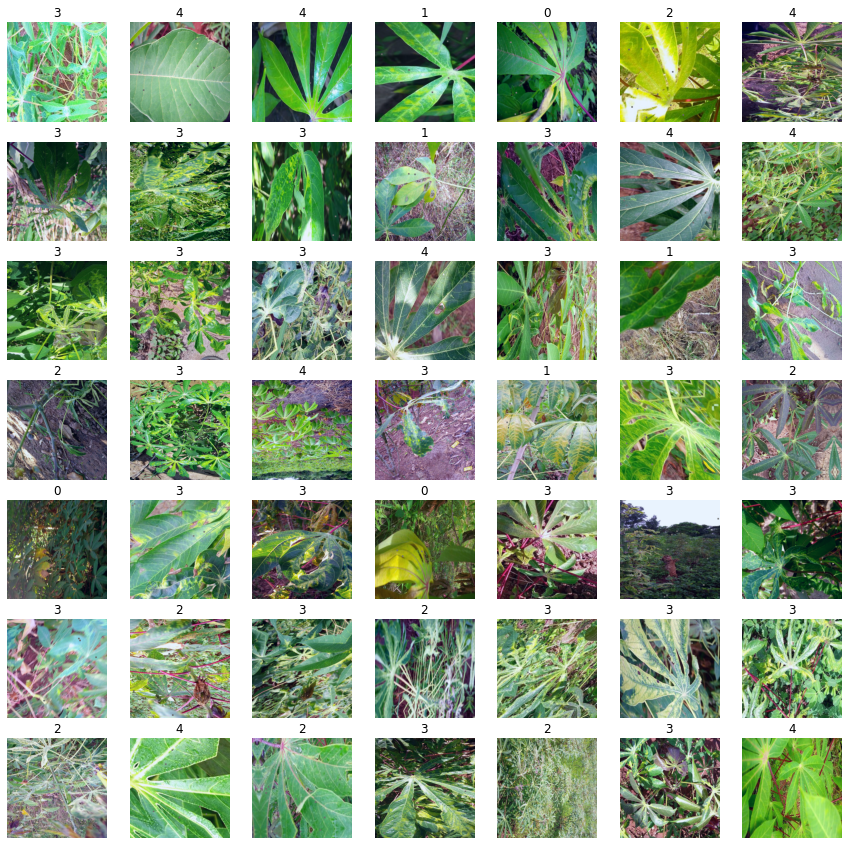

In [15]:
# printing some images and their classes
N_IMAGES = 50

images, labels = zip(*[(image, label) for image, label in 
                           [train_set[i] for i in range(N_IMAGES)]])

classes = [0,1,2,3,4]

plot_images(images, labels, classes)

In [16]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [17]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [18]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [19]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [20]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [21]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)

In [22]:
model = ResNet(resnet34_config, 5)
model.apply(init_weights)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kerne

In [23]:
START_LR = 1e-4
WEIGHT_DECAY = 1e-4

# let's try Adam
optimizer = optim.Adam(model.parameters(), lr=START_LR)

# optimizer = optim.SGD(model.parameters(), lr=START_LR, weight_decay=WEIGHT_DECAY, momentum=.9, nesterov=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = 'cpu'

print("We are running on ", device)

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

We are running on  cuda


In [24]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [25]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].view(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [26]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [27]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
# loading last model uncomment this

# model = ResNet(resnet50_config, 5)
# checkpoint = torch.load('C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/trained_models/trained_model_project_009.t7')
# model.load_state_dict(checkpoint['model_state_dict'])
# model = model.to(device)
# optimizer = optim.Adam(model.parameters(), lr=START_LR)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# best_valid_loss = checkpoint['best_valid_loss']


In [30]:
sample_shuffles = 15
EPOCHS = 3
# loading a pretrained model... Did not do well...

# pretrained_model = models.resnet50(pretrained = True)
# IN_FEATURES = pretrained_model.fc.in_features 
# OUTPUT_DIM = 5

# fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
# pretrained_model.fc = fc
# model = ResNet(resnet50_config, OUTPUT_DIM)
# model.load_state_dict(pretrained_model.state_dict())
# model.to(device)

In [31]:
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, smoothing: float = 0.1, reduction="mean", weight=None):
        super(LabelSmoothingLoss, self).__init__()
        self.epsilon = smoothing
        self.reduction = reduction
        self.weight = weight

    def reduce_loss(self, loss):
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

    def linear_combination(self, x, y):
        return self.epsilon * x + (1 - self.epsilon) * y

    def forward(self, preds, target):
        if self.weight is not None:
            self.weight = self.weight.to(preds.device)

        if self.training:
            n = preds.size(-1)
            log_preds = F.log_softmax(preds, dim=-1)
            loss = self.reduce_loss(-log_preds.sum(dim=-1))
            nll = F.nll_loss(
                log_preds, target, reduction=self.reduction, weight=self.weight
            )
            return self.linear_combination(loss / n, nll)
        else:
            return torch.nn.functional.cross_entropy(preds, target, weight=self.weight)


In [32]:
criterion = LabelSmoothingLoss()
criterion = criterion.to(device)

In [33]:
# if you will continue training you should comment next line
best_valid_loss = float('inf')

for sample in range(sample_shuffles):

    print( '=' *20, ' sample ', sample, ' ', '=' * 20, '\n')
    train_set, val_set = torch.utils.data.random_split(dataset, [17097, 4300])
    val_set.dataset.transform = val_transform
    train_loader = DataLoader(train_set, batch_size = 4, shuffle = True)
    val_loader = DataLoader(val_set, batch_size = 4, shuffle = False)
    scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

    for epoch in range(EPOCHS):
        
        start_time = time.monotonic()
        
        train_loss, train_acc_1, train_acc_5 = train(model, train_loader, optimizer, criterion, scheduler, device)
        valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, val_loader, criterion, device)
            
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/trained_models/tut5-model_project_0010.pt')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
              f'Train Acc @5: {train_acc_5*100:6.2f}%')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
              f'Valid Acc @5: {valid_acc_5*100:6.2f}%')
        
        start_save_time = time.monotonic()
        torch.save({
                'epoch':epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_valid_loss': best_valid_loss,
                'scheduler': scheduler.state_dict()
                
                }, 'C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/trained_models/trained_model_project_0010.t7')
        end_save_time = time.monotonic()

        save_min, save_sec = epoch_time(start_save_time, end_save_time)
        print(f'checkpoint saved in: {save_min}m {save_sec}s')
        end_2 = time.monotonic()

        all_min, all_sec = epoch_time(start_time, end_2)
        print(f'Whole epoch time: {all_min}m {all_sec}s')
        print('\n')

====================  sample  0   ==================== 

Epoch: 01 | Epoch Time: 12m 21s
	Train Loss: 1.225 | Train Acc @1:  60.94% | Train Acc @5: 100.00%
	Valid Loss: 1.831 | Valid Acc @1:  58.49% | Valid Acc @5: 100.00%
checkpoint saved in: 0m 0s
Whole epoch time: 12m 21s


Epoch: 02 | Epoch Time: 12m 23s
	Train Loss: 1.059 | Train Acc @1:  66.30% | Train Acc @5: 100.00%
	Valid Loss: 1.200 | Valid Acc @1:  67.21% | Valid Acc @5: 100.00%
checkpoint saved in: 0m 0s
Whole epoch time: 12m 23s


Epoch: 03 | Epoch Time: 12m 22s
	Train Loss: 0.941 | Train Acc @1:  72.51% | Train Acc @5: 100.00%
	Valid Loss: 1.273 | Valid Acc @1:  76.47% | Valid Acc @5: 100.00%
checkpoint saved in: 0m 0s
Whole epoch time: 12m 23s


====================  sample  1   ==================== 

Epoch: 01 | Epoch Time: 12m 27s
	Train Loss: 0.878 | Train Acc @1:  75.99% | Train Acc @5: 100.00%
	Valid Loss: 1.123 | Valid Acc @1:  75.30% | Valid Acc @5: 100.00%
checkpoint saved in: 0m 0s
Whole epoch time: 12m 28s


Ep

In [34]:
checkpoint = torch.load('C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/trained_models/trained_model_project_0010.t7')
model.load_state_dict(checkpoint['model_state_dict'])



<All keys matched successfully>

In [35]:
# testing the model
model = ResNet(resnet34_config, 5)

checkpoint = torch.load('C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/trained_models/trained_model_project_0010.t7')
model.load_state_dict(checkpoint['model_state_dict'])
criterion = LabelSmoothingLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# test_loss, test_acc_1, test_acc_5 = evaluate(model, val_loader, criterion, device)

# print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
#       f'Test Acc @5: {test_acc_5*100:6.2f}%')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kerne

In [36]:
test_dataset = CassavaDateset(submission, 'C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/test_images', val_transform)
test_loader = DataLoader(test_dataset, batch_size = 10, shuffle=False)


In [37]:
# testing the model
model = ResNet(resnet34_config, 5)

checkpoint = torch.load('C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/trained_models/trained_model_project_0010.t7')
model.load_state_dict(checkpoint['model_state_dict'])
criterion = LabelSmoothingLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 1.296 | Test Acc @1:   0.00% | Test Acc @5: 100.00%


In [38]:
model = ResNet(resnet34_config, 5)

checkpoint = torch.load('C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/trained_models/trained_model_project_0010.t7')
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [39]:
import random
import cv2

class Infer_set(Dataset):
    def __init__(self, path, transforms, device):
        super(Infer_set, self).__init__()
        import os
        import cv2
        self.path = path
        self.device = device
        self.transforms = transforms
        self.img_list = [img for img in os.listdir(path) if img.endswith('.jpg')]
#         random.shuffle(self.img_list)
#         print(self.img_list)
        
        
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.path, self.img_list[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms is not None:
            augmented = self.transforms(image=image)
            image = augmented['image']
        return image.to(self.device), self.img_list[idx]
        
        
        
    def __len__(self):
        return len(self.img_list)
        
        
        
    def __len__(self):
        return len(self.img_list)
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
    
infer_set = Infer_set(path='C:/Users/malji/Datasets/project/cassava-leaf-disease-classification/test_images', transforms=val_transform, device=device)
infer_loader = DataLoader(infer_set, batch_size=32, shuffle=False)
infer_loader.__iter__().__next__()[0].shape
# infer_loader.batch_size


torch.Size([1, 3, 512, 512])

In [40]:
f = open('./submission.csv', 'w')
f.write('image_id,label\n')
idx = 0

with torch.no_grad():
    model.eval()
    for i, (image, fns) in enumerate(infer_loader):
#         print(image.shape)
        preds = model(image)
        preds = preds[0].argmax(1).squeeze().cpu().numpy()
#         print(preds)

        if len(fns)>1:
            for (pred, fn) in zip(preds, fns):
                f.write(fn + ',' + str(pred) + '\n')
                idx += 1
        else:
            f.write(fns[0] + ',' + str(preds) + '\n')
            idx += 1
f.close()


In [41]:
f = open('./submission.csv', 'r')

print(f.readlines())

f.close()


['image_id,label\n', '2216849948.jpg,2\n']
